In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sn

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import random_split

# Problem 1:

## Download 4 Points

In [3]:
!mkdir -p data
!mkdir -p data/train

!wget -O data/train/img_0.jpg -nc -q https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/img_0.jpg
!wget -O data/train/img_1.jpg -nc -q https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/img_1.jpg
!wget -O data/train/img_2.jpg -nc -q https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/img_2.jpg
!wget -O data/train/img_3.jpg -nc -q https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/img_3.jpg
!wget -O data/train/labels.npy -nc -q https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/labels.npy

In [4]:
class ImageDataset(Dataset):
  def __init__(self, img_dir, label_file):
    super(ImageDataset, self).__init__()
    self.img_dir = img_dir
    self.labels = torch.tensor(np.load(label_file, allow_pickle=True))
    self.transforms = transforms.ToTensor()
  
  def __getitem__(self, idx):
    img_pth = os.path.join(self.img_dir, "img_{}.jpg".format(idx))
    img = Image.open(img_pth)
    img = self.transforms(img).flatten()
    label = self.labels[idx]
    return {"data":img, "label":label}
  
  def __len__(self):
    return len(self.labels)

In [5]:
train_dataset = ImageDataset(img_dir='./data/train/',
                             label_file='./data/train/labels.npy')

train_loader = DataLoader(train_dataset, 
                          batch_size=4, 
                          shuffle=True)

In [6]:
for minibatch in train_loader:
  data, labels = minibatch['data'], minibatch['label']
  print(data)
  print(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0, 2, 4, 1])


## Test

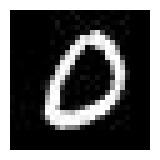

[(0.0, 28.0), (28.0, 0.0), None]

In [7]:
ndata=data.view(4,28,28).detach().numpy()
scale = 5 
im_data = ndata[0]
dpi = matplotlib.rcParams['figure.dpi']
height, width = im_data.shape
figsize = scale * width / float(dpi), scale * height / float(dpi)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
# Hide spines, ticks, etc.
ax.axis('off')
ax.imshow(im_data, vmin=0, vmax=1, cmap='gray')
plt.show()
ax.set(xlim=[0, width], ylim=[height, 0], aspect=1)

## PCA on 4 Points

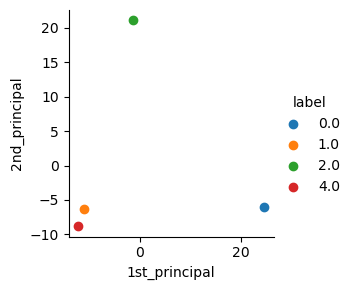

n_components=2: (eigenvalues=[29.496016 24.441822], var=[0.45502877 0.31244913])
n_components=0.99: (eigenvalues=[29.496017 24.441813 21.085123], var=[0.4550289  0.31244892 0.23252222])
shape of cov_mat: (784, 784)


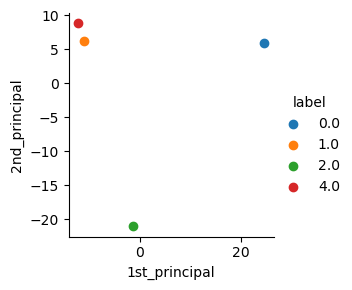

In [44]:


for minibatch in train_loader:
    data, labels = minibatch['data'], minibatch['label']
    scaler = StandardScaler()
    X = scaler.fit_transform(data.numpy())
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X)

    pca_data = np.vstack((reduced_data.T, labels)).T
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
    sn.FacetGrid(pca_df, hue="label").map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.show()

    print(f'n_components=2: (eigenvalues={pca.singular_values_}, var={pca.explained_variance_ratio_})')

    pca = PCA(n_components=0.99, svd_solver='auto')
    reduced_data = pca.fit_transform(X)

    # pca_data = np.vstack((reduced_data.T, labels)).T
    # pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
    # sn.FacetGrid(pca_df, hue="label").map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    # plt.show()

    print(f'n_components=0.99: (eigenvalues={pca.singular_values_}, var={pca.explained_variance_ratio_})')

    covariance_matrix = np.cov(X, ddof = 1, rowvar = False)

    print('shape of cov_mat:', covariance_matrix.shape)

    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    
    # np.argsort can only provide lowest to highest; use [::-1] to reverse the list
    order_of_importance = np.argsort(eigenvalues)[::-1] 

    # utilize the sort order to sort eigenvalues and eigenvectors
    sorted_eigenvalues = eigenvalues[order_of_importance]
    sorted_eigenvectors = eigenvectors[:,order_of_importance] # sort the columns
    
    # use sorted_eigenvalues to ensure the explained variances correspond to the eigenvectors
    explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

    # print(f'numpy: (eigenvalues={sorted_eigenvalues[:2]}, var={explained_variance[:2]})')

    k = 2 # select the number of principal components
    reduced_data = np.matmul(X, sorted_eigenvectors[:,:k]).real # transform the original data


    pca_data = np.vstack((reduced_data.T, labels)).T
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
    sn.FacetGrid(pca_df, hue="label").map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.show()

These are the similar results but 1st and 2nd principal are changed (x and y axes are flipped)

## PCA on MNIST

In [21]:
test_dataset = datasets.MNIST(root='./data/', train=False, download= True, transform=transforms.ToTensor())
length=len(test_dataset)
test_data, _ = random_split(test_dataset, [int(length/4), length - int(length/4)], torch.Generator().manual_seed(42))

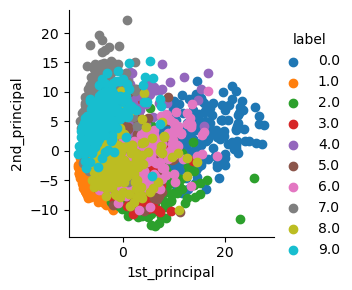

n_components=2: (eigenvalues=[328.312   267.39743], var=[0.06747331 0.04475823])
n_components=0.99: (eigenvalues=[328.31192   267.3974    257.62158   229.13211   217.43462   201.35616
 183.06398   180.20135   166.44815   161.26115   157.02655   149.85417
 146.48288   141.44576   140.0831    137.60918   135.10204   133.01936
 126.76211   125.16599   124.28719   122.10526   121.75734   121.02499
 117.18458   116.71128   114.493706  113.032074  111.71567   110.106865
 108.56846   105.37345   104.83329   104.00411   102.34528   101.52652
 100.33418    99.52088    99.17838    98.349976   96.416115   95.96739
  94.265526   93.428276   92.28855    91.31641    90.29164    89.603294
  89.19964    88.71624    87.255615   86.47323    86.05316    85.492645
  84.37844    83.20649    82.84735    82.498245   81.906334   81.12046
  80.668564   80.29925    79.78235    78.920044   78.31974    78.09795
  76.51799    75.834496   75.34887    74.50025    74.0016     73.00515
  72.35509    71.78595    71.667

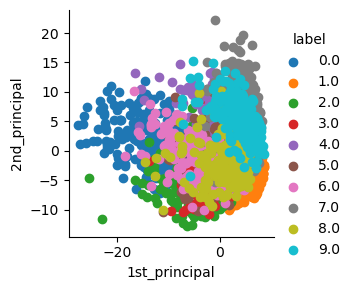

In [22]:
data = [sample.numpy() for sample, _ in iter(test_data)]
labels = [label for _, label in iter(test_data)]
data = np.array(data).reshape(2500,784)
    
scaler = StandardScaler()
X = scaler.fit_transform(data)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)

pca_data = np.vstack((reduced_data.T, labels)).T
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label").map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

print(f'n_components=2: (eigenvalues={pca.singular_values_}, var={pca.explained_variance_ratio_})')

pca = PCA(n_components=0.99, svd_solver='auto')
reduced_data = pca.fit_transform(X)

# pca_data = np.vstack((reduced_data.T, labels)).T
# pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
# sn.FacetGrid(pca_df, hue="label").map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
# plt.show()

print(f'n_components=0.99: (eigenvalues={pca.singular_values_}, var={pca.explained_variance_ratio_})')

covariance_matrix = np.cov(X, ddof = 1, rowvar = False)

print('shape of cov_mat:', covariance_matrix.shape)

eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)


# np.argsort can only provide lowest to highest; use [::-1] to reverse the list
order_of_importance = np.argsort(eigenvalues)[::-1] 

# utilize the sort order to sort eigenvalues and eigenvectors
sorted_eigenvalues = eigenvalues[order_of_importance]
sorted_eigenvectors = eigenvectors[:,order_of_importance] # sort the columns

# use sorted_eigenvalues to ensure the explained variances correspond to the eigenvectors
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

# print(f'numpy: (eigenvalues={sorted_eigenvalues[:2]}, var={explained_variance[:2]})')

k = 2 # select the number of principal components
reduced_data = np.matmul(X, sorted_eigenvectors[:,:k]).real # transform the original data


pca_data = np.vstack((reduced_data.T, labels)).T
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label").map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

# Problem 2:

In [2]:
import torch
ten1 = torch.rand((2,3))
ten2 = torch.rand((2,3))
tenA = third_tensor = torch.cat((ten1, ten2), 1)
tenA.shape

torch.Size([2, 6])

In [8]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import v2

plt.rcParams["savefig.bbox"] = 'tight'

# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)

# If you're trying to run that on collab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
# from helpers import plot
orig_img = Image.open('cup.jpg')

def plot(images, rows=1):
    for num, img in enumerate(images):
        plt.subplot(rows,6,num+1)

        plt.axis('off')
        plt.imshow(img)

## Random Rotation

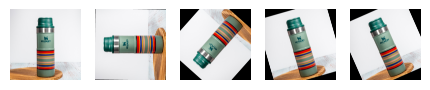

In [9]:
rotater = v2.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(orig_img) for _ in range(4)]

plot([orig_img]+rotated_imgs)



# Random Translation-and-Resizing

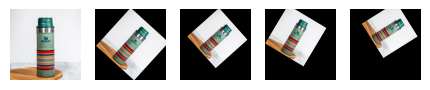

In [10]:
affine_transfomer = v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transfomer(orig_img) for _ in range(4)]
plot([orig_img] + affine_imgs)

## Both Augmentation

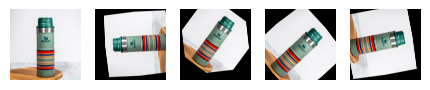

In [17]:
rotater = v2.RandomRotation(degrees=(0, 180))
affine_transfomer = v2.RandomAffine(degrees=(50, 90), translate=(0.1, 0.15), scale=(0.9, 1))

rotated_imgs = [affine_transfomer(rotater(orig_img)) for _ in range(4)]

plot([orig_img] + rotated_imgs)